# Instructions

***Instructions to execute this code
- Ensure the csv files are stored in same location as this notebook
- If you have Anaconda installed. Open this code from the localhost path and run it
- If you have Visual Studio Code. Open this code on Visual Studio Code and use the shortcut Ctrl+Alt+N to run it.
- If you are on Windows, click on the "Start" button, go to the "cmd" app, go to the folder path where the file is stored, then type "python [filename.py]"
- If your case is not listed, please reach out!

# Problem Definition

The problem we are trying to solve is :
- use features of a product to predict which family it belongs to.
- specically these features are the product length, product depth, product width and product weight to predict if the product is of "meuble" or "mlp" or "deco" activity.
- This is a multiclassification problem.

# Contents

**Part 0 : Environnement Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset Import</a>
 
**Part 1 : EDA**
 - <a href="#C4">Dataset Overview</a>
 - <a href="#C5">Duplicates</a>
 - <a href="#C6">Outliers</a>
 - <a href="#C7">Relationship between TARGET activity and variables</a>
 - <a href="#C8">Relationship between variables</a>

**Part 2 : Preprocessing**
 - <a href="#C9">Encoding</a>
 - <a href="#C10">Train Test Split</a>
 - <a href="#C11">Baseline</a>
 - <a href="#C12">Features Selection</a>
 
**Part 3a : Modeling - Supervised classification**
 - <a href="#C13">Evaluation Metric</a>
 - <a href="#C14">KNN</a>
 
**Part 3b : Modeling - Clustering**
 - <a href="#C15">Evaluation Metric</a>
 - <a href="#C16">KMeans</a>
 
**Part 4 : Conclusions**

# Part 0 : Environnement Setup

# <a name="C1">Importation of libraries</a>

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Importing libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn import cluster, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline

In [3]:
# Dislaying versions of libraries
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


# <a name="C2">Definition of functions</a>

In [4]:
scaler_list = [MinMaxScaler(feature_range=(0, 1)), StandardScaler(), RobustScaler()]  

def modelisation(X_train, y_train, X_test, y_test, estimator):
    '''Modelisation function that returns for an algo, the result based on different pre-treatments'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', StandardScaler()), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring = "accuracy")

    grid.fit(X_train, y_train)
    
    y_pred_test = grid.predict(X_test)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='micro'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='micro'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='micro'),3)
    result = result[['estimator','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score']]

    return result

In [5]:
def evaluation(model, X_train, y_train, X_test, y_test, index_act):
    '''Evaluation function that returns for a supervised classification algo, the performance metrics'''    
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

    conf_mat = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(conf_mat, index = index_act, columns = index_act)
    plt.figure(figsize = (5,5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# <a name="C3">Dataset Import</a>

In [6]:
# Importing the file
dataset = pd.read_csv('dataset.csv')

# Part 1 : EDA

Objective: Better understand the dataset

# <a name="C4">Dataset Overview</a>

### Dataset format overview 

In [7]:
# Displaying first rows of the file
dataset.head()

,height,width,depth,weight,activity
0,90.5,42.0,2.0,1.25,mlp
1,60.0,50.0,2.0,1.20,mlp
2,80.0,59.6,2.0,7.40,mlp
3,46.0,46.0,2.0,1.45,mlp
4,93.0,21.0,2.0,1.30,mlp


In [8]:
# Displaying shape of the file
dataset.shape

(900, 5)

In [9]:
# Displaying NaNs and types for each column
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   height    900 non-null    float64
 1   width     900 non-null    float64
 2   depth     900 non-null    float64
 3   weight    900 non-null    float64
 4   activity  900 non-null    object 
dtypes: float64(4), object(1)
memory usage: 35.3+ KB


In [10]:
# Displaying unique values for activity
dataset['activity'].unique()

array(['mlp', 'deco', 'meuble'], dtype=object)

Comments - Dataset format overview
- The file is well imported
- It has 900 products and 5 variables describing the product
- Amid the 5 variables, 4 are quantitative and 1 is qualitative
- The qualitative variable, which is the variable TARGET, has 3 unique values.
- It has no NaN - it is complete

### Dataset content overview 

In [11]:
# Examining the target
dataset['activity'].value_counts(normalize=True)

mlp       0.333333
deco      0.333333
meuble    0.333333
Name: activity, dtype: float64

In [12]:
# Examining the other variables
dataset.describe()

,height,width,depth,weight
count,900.000000,900.000000,900.000000,900.000000
mean,76.500333,81.840889,43.665222,17.338164
std,48.964657,64.233793,50.582235,38.186996
min,1.600000,7.000000,1.200000,1.010000
25%,42.375000,39.000000,8.750000,1.915000
50%,74.000000,60.000000,32.000000,4.600000
75%,90.000000,100.000000,51.250000,14.000000
max,300.000000,370.000000,350.000000,800.000000


In [13]:
# From the above, we could assume that the heaight, width and depth are in cm unit. The weight is in kg.
# Renaming the quantitative values for a common and better understanding of the variable [assuming the BUs have confirmed the assumption]
dataset.columns = ['height_cm', 'width_cm', 'depth_cm', 'weight_kg', 'activity']
dataset.columns

Index(['height_cm', 'width_cm', 'depth_cm', 'weight_kg', 'activity'], dtype='object')

In [14]:
# Listing quantitative variables
col_quant = dataset.select_dtypes(include = ['int64','float64']).columns.tolist()

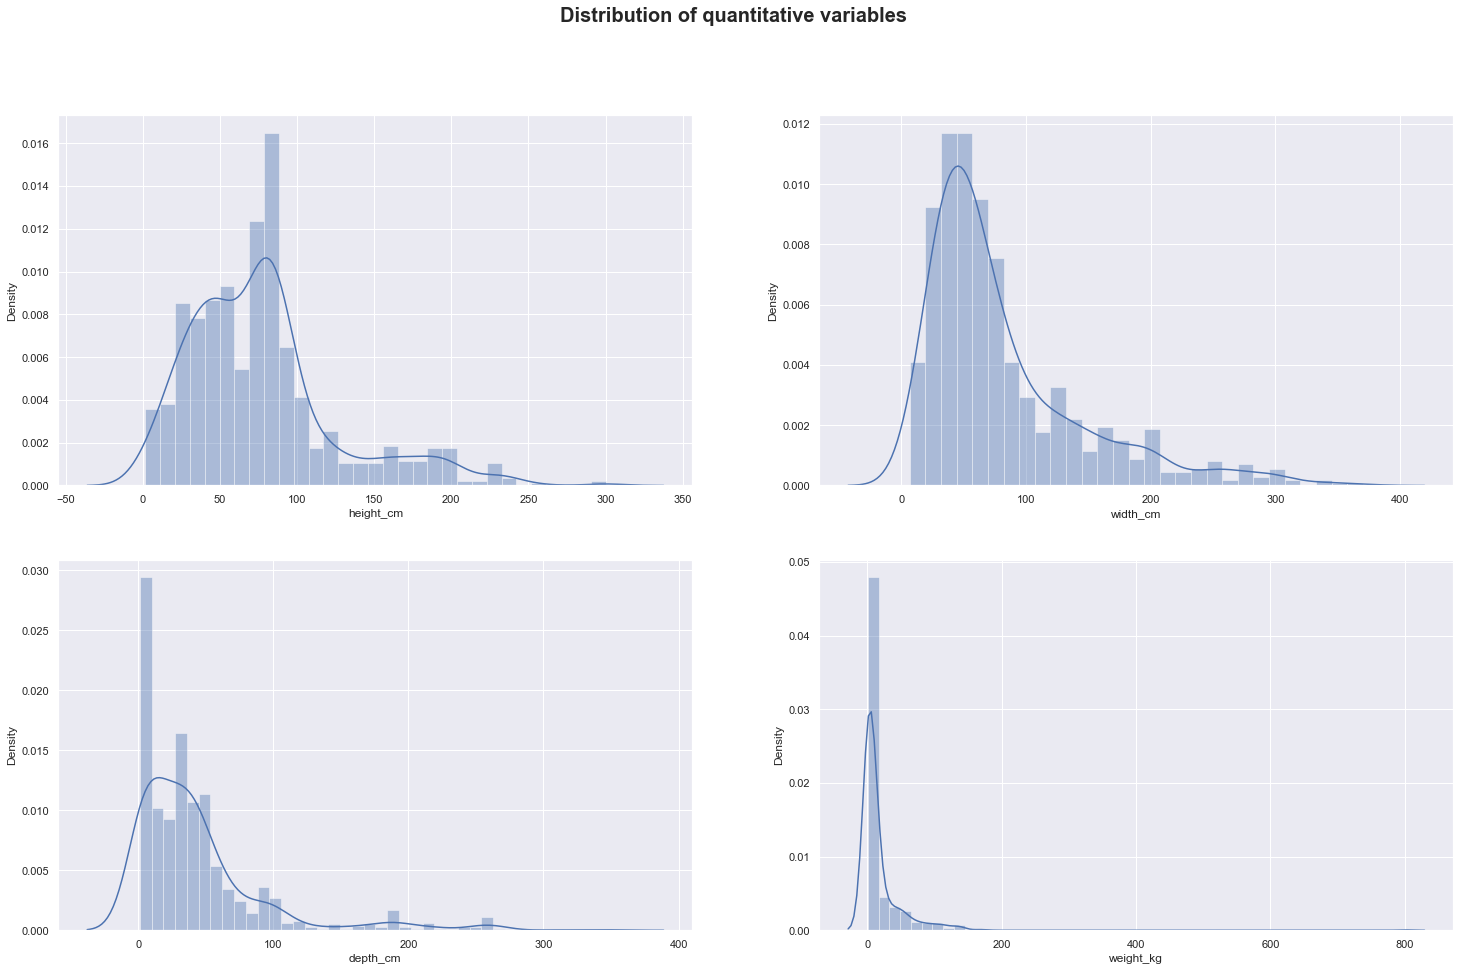

In [15]:
# Analysing order of magnitude for each variable - histogram
fig = plt.figure(figsize=(25,15))

for i, col in enumerate(col_quant,1):
    ax = fig.add_subplot(2,2,i)
    sns.distplot(dataset[col])

plt.suptitle('Distribution of quantitative variables', fontsize=20,
             fontweight='bold')

plt.show()

Comments - Dataset content overview
- TARGET activity values are balanced in the dataset, which makes it a good dataset for the objective of classifying ! No issue with imbalanced data.
- [To be confirmed with the BUs] The other variables are related to the size and weight of the products. Given the products are furniture/decoration and the 'height' is between 1.6 and 300 with a 50% quartile of 74, we will assume its unit is in cm. With the same logic, we are making the same assumption for 'width' and 'depth' being in cm. The weigth is between 1 and 800, with a 50% quartile of 4.6. So we will assume its unit is in kg.
- All quantitive variables have an assymetric distribution - right skewed. Given the assymetry, it would be wise to normalise the distribution before modeling, for better results.

# <a name="C5">Duplicates</a>

In [16]:
# Searching duplicates in the dataset
dataset.duplicated().sum()

18

In [17]:
# Removing duplicates in the dataset
dataset.drop_duplicates(inplace=True)
dataset.duplicated().sum()

0

In [18]:
# Checking if a product with same measures got classified in more than one activity.
dataset_temp = dataset[['height_cm', 'width_cm', 'depth_cm', 'weight_kg']]
dataset_temp.duplicated().sum()

0

In [19]:
# Displaying new shape of the dataset
dataset.shape

(882, 5)

Comments:
- Duplicates got removed, and no products with same physical characteristics is classified in more than one activity
- The dataset has now 882 products with different characteristics

# <a name="C6">Outliers</a>

In [20]:
# Displaying variables statistics for each quantitative columns
dataset.describe()

,height_cm,width_cm,depth_cm,weight_kg
count,882.000000,882.000000,882.000000,882.000000
mean,76.601247,80.633560,42.194671,16.584295
std,49.348822,62.711274,48.536714,37.348616
min,1.600000,7.000000,1.200000,1.010000
25%,42.000000,39.000000,8.000000,1.900000
50%,74.000000,60.000000,30.750000,4.360000
75%,90.000000,100.000000,50.000000,13.587500
max,300.000000,370.000000,350.000000,800.000000


In [21]:
# At first sight, no "visible" outliers. 800kg for a product? Let's say maybe ! The range for each variable is possible.
# Let's consider some new variables to identify possible outliers

In [22]:
# Creating the volume feature
dataset['volume_cm3']=dataset['height_cm']*dataset['width_cm']*dataset['depth_cm']

Text(0.5, 1.0, 'Products distribution based on their weight and volume')

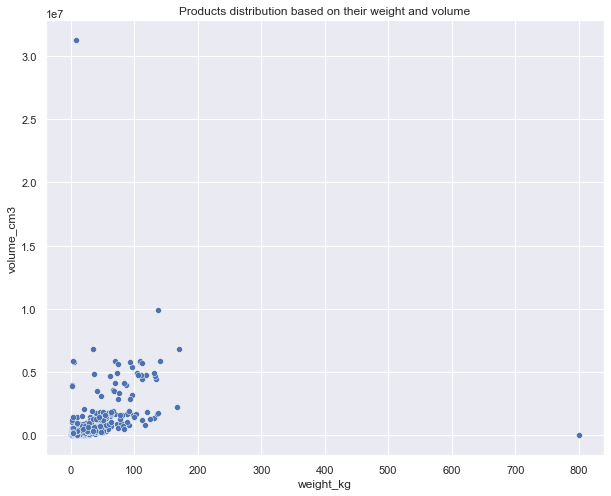

In [23]:
# Visualising the distribution of the products based on their weight and volume
plt.figure(figsize=(10,8))
sns.scatterplot(data=dataset, x="weight_kg", y='volume_cm3')
plt.title("Products distribution based on their weight and volume")

In [24]:
# Checking closer the outliers by looking at products with a weight higher than 200kg and volume higher than 1e7 cm3
dataset_temp = pd.concat([dataset[dataset['weight_kg']>200], dataset[dataset['volume_cm3']>1e7]], axis=0)
dataset_temp

,height_cm,width_cm,depth_cm,weight_kg,activity,volume_cm3
135,13.5,30.0,20.0,800.0,mlp,8100.0
899,255.0,350.0,350.0,8.0,meuble,31237500.0


In [25]:
# These products are definitely outliers as cannot exist with such characteristics. Given the number of outliers of 2, they can be removed from the dataset.
dataset = dataset[dataset['weight_kg']<200]
dataset = dataset[dataset['volume_cm3']<1e7]
dataset.shape

(880, 6)

Text(0.5, 1.0, 'Products distribution based on their weight and volume')

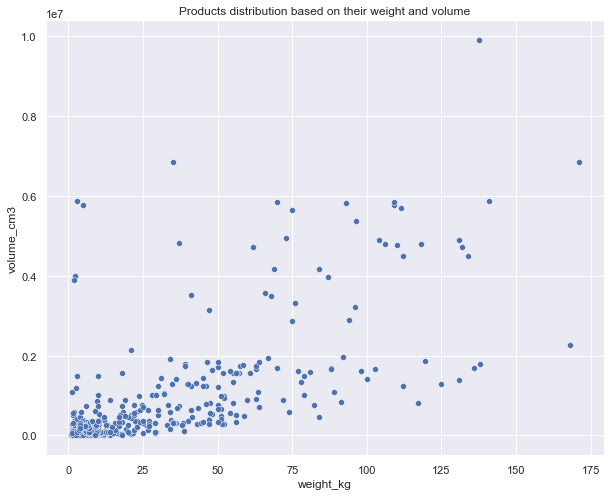

In [26]:
# Visualising the distribution of the products based on their weight and volume
plt.figure(figsize=(10,8))
sns.scatterplot(data=dataset, x="weight_kg", y='volume_cm3')
plt.title("Products distribution based on their weight and volume")

In [27]:
# Creating a new variable density
dataset['density_kgcm3'] = dataset['weight_kg']/dataset['volume_cm3']

In [28]:
# Displaying variables statistics for each quantitative columns
dataset.describe()

,height_cm,width_cm,depth_cm,weight_kg,volume_cm3,density_kgcm3
count,880.000000,880.000000,880.000000,880.000000,8.800000e+02,8.800000e+02
mean,76.470227,80.385000,41.870114,15.703805,4.382534e+05,1.775112e-04
std,48.990745,62.097723,47.462835,26.438751,1.049051e+06,1.290117e-03
min,1.600000,7.000000,1.200000,1.010000,8.050000e+01,4.629630e-07
25%,42.000000,39.000000,8.000000,1.900000,2.066362e+04,3.229408e-05
50%,74.000000,60.000000,30.750000,4.310000,7.200000e+04,7.136540e-05
75%,90.000000,100.000000,50.000000,13.462500,3.027900e+05,1.507541e-04
max,300.000000,370.000000,315.000000,171.000000,9.906750e+06,3.776398e-02


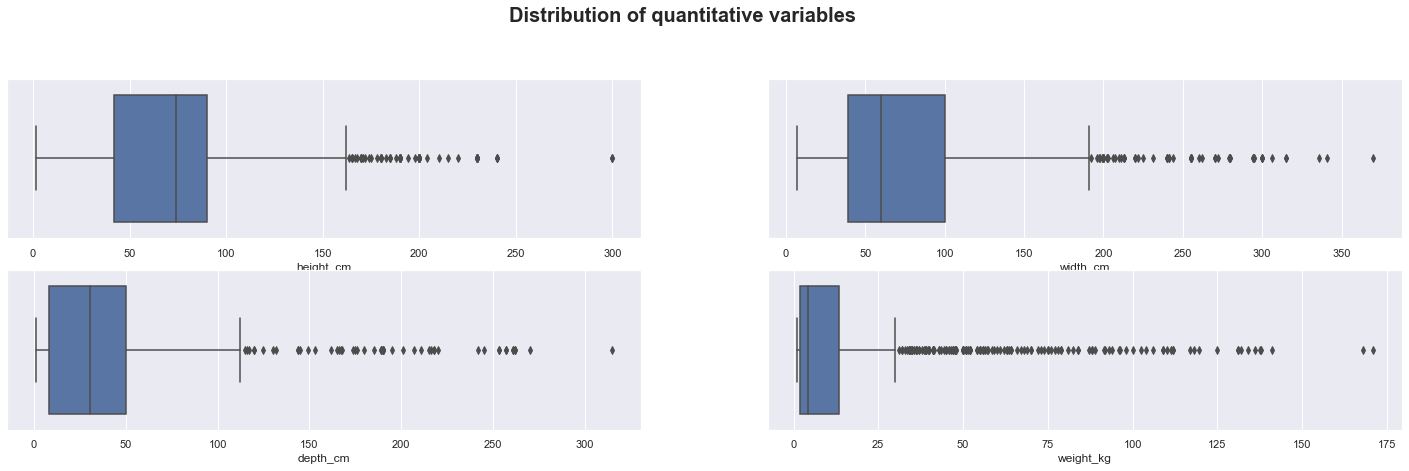

In [29]:
# Analysing order of magnitude for each variable - histogram
fig = plt.figure(figsize=(25,10))

for i, col in enumerate(col_quant,1):
    ax = fig.add_subplot(3,2,i)
    sns.boxplot(dataset[col])

plt.suptitle('Distribution of quantitative variables', fontsize=20,
             fontweight='bold')

plt.show()

In [30]:
# Checking closer the outliers by looking at products with a weight higher than 200kg and volume higher than 1e7 cm3
dataset_temp = dataset[dataset['density_kgcm3']>0.005]
dataset_temp

,height_cm,width_cm,depth_cm,weight_kg,activity,volume_cm3,density_kgcm3
286,2.5,7.0,4.6,3.04,mlp,80.5,0.037764


In [31]:
# These products are definitely outliers as cannot exist with such characteristics. Given the number of outliers of 2, they can be removed from the dataset.
dataset = dataset[dataset['density_kgcm3']<0.005]
dataset.shape

(879, 7)

Comments - Outliers:
- No immediate outliers identified looking at variables individually (assuming maybe a product with a 800kg weight could be possible)
- 2 outliers got identified by considering a new variable - volume of the product - and comparing it to the weight of the product. Which automatically remove the product with a 800kg weight too.
- The dataset has now 879 products with different and possible characteristics
- Note that some techniques to remove outliers such as z-score could be used. Given the small size of the dataset and the types of variables, we will not consider and will keep all the remaining products.

# <a name="C7">Relationship between TARGET activity and variables</a>

Text(0.5, 1.0, 'Target distribution')

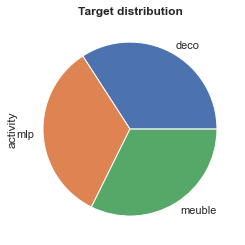

In [32]:
# Visualising target distribution
dataset['activity'].value_counts(normalize=True).plot(kind='pie')
plt.title('Target distribution', fontsize=12, fontweight='bold')

In [33]:
# Listing quantitative variables
col_quant = dataset.select_dtypes(include = ['int64','float64']).columns.tolist()

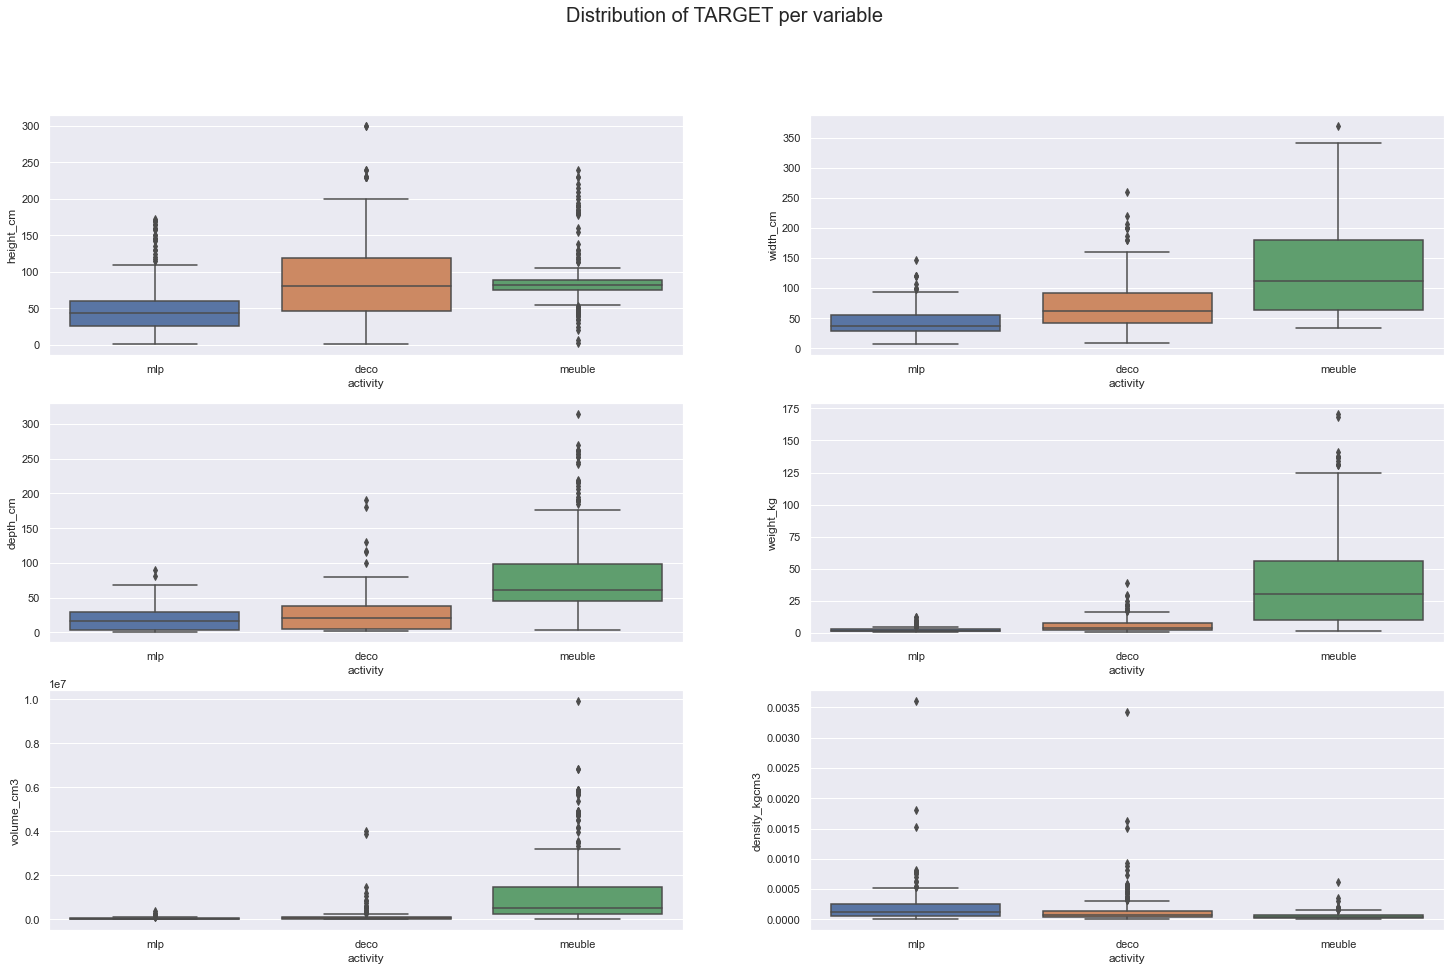

In [34]:
# Visualising activity for each quantitative feature (ANOVA)
fig = plt.figure(figsize=(25,15))
plt.suptitle('Distribution of TARGET per variable', fontsize=20)

for i, c in enumerate(col_quant,1):
    ax = fig.add_subplot(3,2,i)
    sns.boxplot(data=dataset, x='activity', y=c, ax=ax)

plt.show()

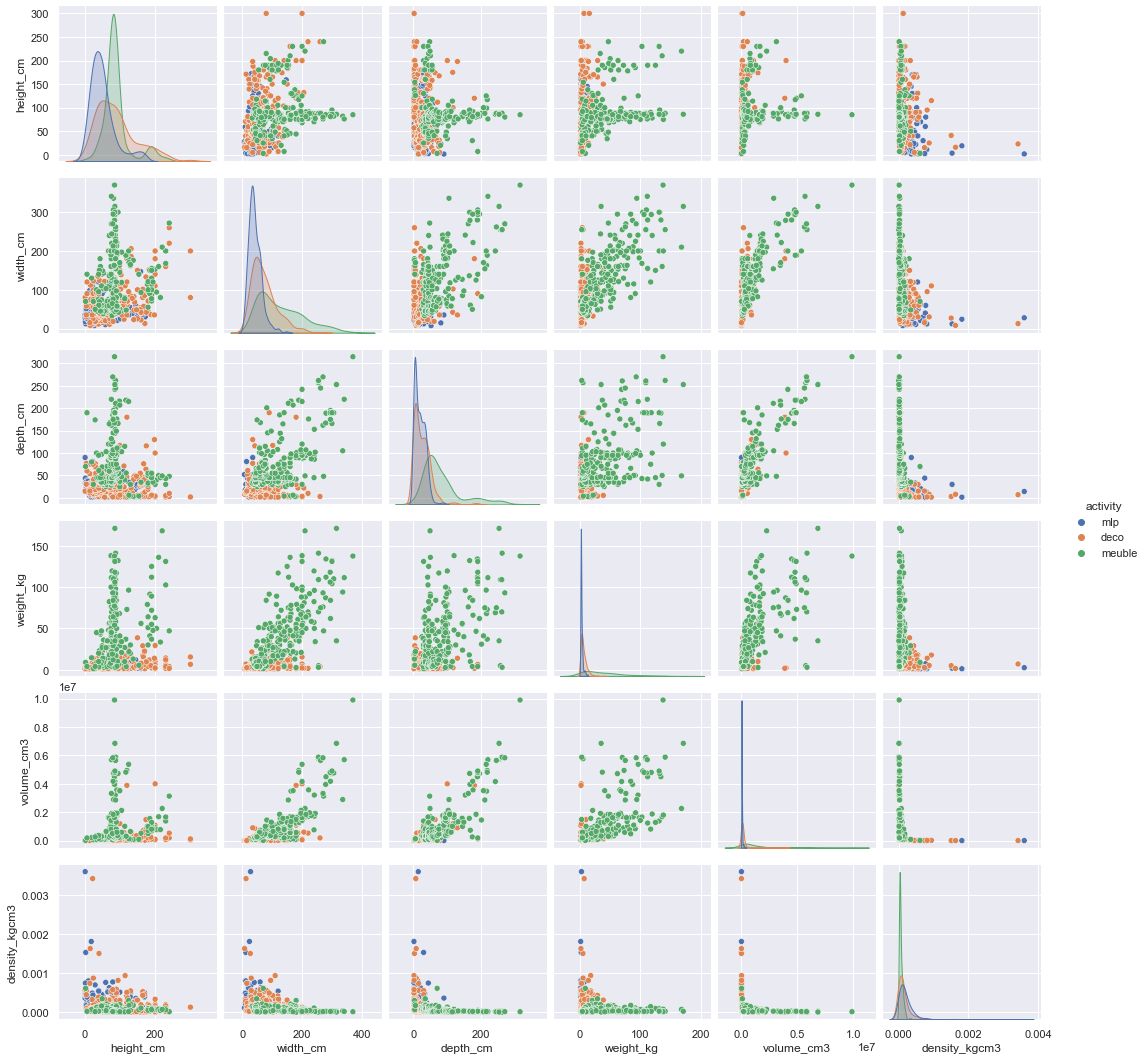

In [35]:
# Analysing pairplots
sns.pairplot(dataset, hue='activity')

# <a name="C8">Relationship between variables</a>

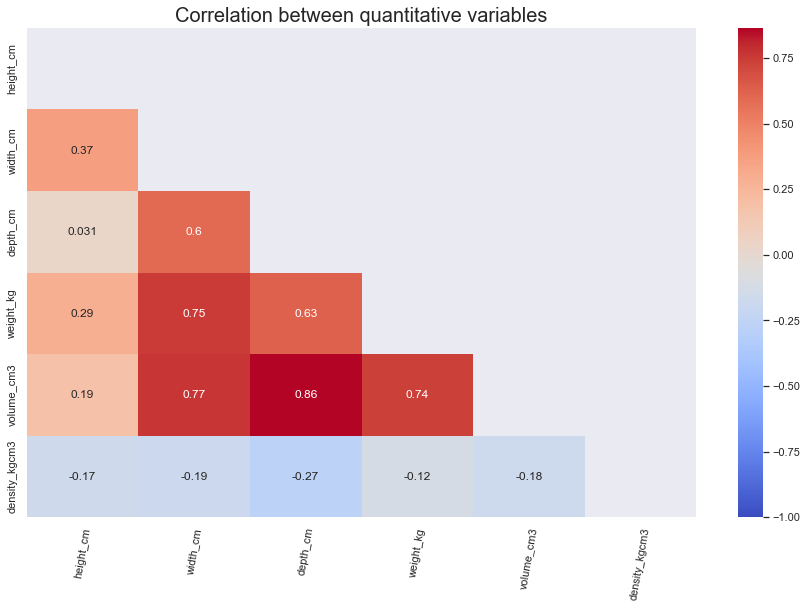

In [36]:
# Displaying heatmap correlation between quantitative variables
plt.figure(figsize=(15,9))
plt.title('Correlation between quantitative variables', fontsize = 20)

corr = dataset.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = True)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

Comments - Relationship activity / variables:
- No clear cut, overlap found on pariplots graph
- ANOVA allows to identify some possible links between the target and the other variables. 
- The activity "meuble" has clearly a higher depth, weight, volume and width.
- The activities "mlp" and "deco" are very close, with some differences in height and width, where the "deco" is higher.
- All are hypothesis to check
- Height has no correlation with other variables. Same for density.
- Some correalations among width, depth and weight.

# Part 2 : Preprocessing

Objective: Transform the dataset into a ready format for ML

# <a name="C9">Encoding</a>

In [37]:
# Encoding the target with Labelencoder
encoder = LabelEncoder()
dataset['activity'] = encoder.fit_transform(dataset['activity'])

In [38]:
# Saving the list of activities for later use
index_act = encoder.inverse_transform(np.array([0,1,2]))
l_cat = list(index_act)
l_cat

['deco', 'meuble', 'mlp']

# <a name="C10">Train Test Split</a>

In [39]:
# Creating the features dataset
X = dataset.drop('activity', axis=1)
# Creating the target dataset
y = dataset['activity']

In [40]:
# Spliting the dataset into train and test set 80/20 split
# final model is evaluated on the test set that is not used in the training process.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = 0.2 ,random_state= 0 ,stratify = dataset.activity) would have been used if imbalanced dataset

In [41]:
# Ensuring the balance distribution of activities kept after the split on the train set
y_train.value_counts()

2    241
0    240
1    222
Name: activity, dtype: int64

In [42]:
# Ensuring the balance distribution of activities kept after the split on the test set
y_test.value_counts()

1    62
0    60
2    54
Name: activity, dtype: int64

# <a name="C11">Baseline</a>

In [43]:
# Defining a baseline as a reference to ensure it is worthwhile modeling further and if worthwhile, that my models are better.
# Given our dataset has 3 different activities that are evenly balanced, we would expect to have a model accuracy of around 0.33 with guessing.
# Creating the simplest model - Dummy estimator
dum = DummyClassifier(strategy="most_frequent")

In [44]:
# Training this estimator on training set
dum.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [45]:
# Displaying accuracy on test set
y_pred_dum = dum.predict(X_test)
print("accuracy dum :", round(accuracy_score(y_test, y_pred_dum),3))

accuracy dum : 0.307


# <a name="C12">Feature Selection</a>

The dataset has now 6 features. 
Let's start simple to complex, by considering few features, all features and best features.

### Dataset - all features

In [46]:
# Option 0: All dataset features (initial + new ones)
X_train.columns

Index(['height_cm', 'width_cm', 'depth_cm', 'weight_kg', 'volume_cm3',
       'density_kgcm3'],
      dtype='object')

### Dataset - initial features

In [47]:
# Option 1: Initial dataset features
X_train_1 = X_train[['height_cm', 'width_cm', 'depth_cm', 'weight_kg']]
X_test_1 = X_test[['height_cm', 'width_cm', 'depth_cm', 'weight_kg']]

### Dataset - best features

In [48]:
# Option 2: Best features with VIF - Variance Inflation Factor
X_train_vif = X_train.copy()
vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif_info['Column'] = X_train_vif.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
1,6.930829,width_cm
4,4.733215,volume_cm3
2,4.608134,depth_cm
3,3.223906,weight_kg
0,3.216513,height_cm
5,1.168324,density_kgcm3


In [49]:
# The result above is logical. More correlated variables noticed in the correlation matrice higher up have the highest VIF.
# Removing variables with VIF higher than 5
X_train_2 = X_train[['height_cm', 'depth_cm', 'weight_kg', 'volume_cm3',
       'density_kgcm3']]
X_test_2 = X_test[['height_cm', 'depth_cm', 'weight_kg', 'volume_cm3',
       'density_kgcm3']]

Comments:
- The dataset got preprocessed with only encoding the target. 
- The dataset got split into training and test to avoid bias. Also, given the dataset is balanced across the activities, only a random was considered. If it was not the case, a "stratify" would have been used to ensure the split represents the right proportions.
- A baseline is computed to serve as a reference to ensure it is worthwhile modeling further and if worthwhile, that my models are better. Given the dataset has 3 different activities that are evenly balanced, we would expect to have a model accuracy of around 0.33 with guessing, which is what we get with the Dummy
- The features variables are 6 - 4 in initial dataset and 2 new. It is an iterative process, but we will start to consider the full dataset, then only the initial features, then the best features and then get into a more complex combinations... to see how the performance evolves.

# Part 3a : Modeling - Supervised Classification

# <a name="C13">Evaluation metric</a>

Given it is a multi classification, we will consider both Accuracy and Confusion matrix, as both metrics as allow to observe in which way the model is wrong (or right!). 

# <a name="C14">KNN</a>

The choice for KNN is justified by:
- the problem being a multiclassfication problem, and widely used in multiclass
- small dataset (not ideal with large dataset)
- small number of features
- not impacted by outliers
- some features slightly correlated
- BUT features to be all scaled

In [50]:
# Searching for best optimum scaler params for KNN.- optimisation done on scaling, but can be further develop to include hyperparameters of algo...
model = KNeighborsClassifier()

modelisation(X_train, y_train, X_test, y_test, model)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,estimator,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score
0,KNeighborsClassifier(),{'scaler': MinMaxScaler()},0.796606,0.011202,0.818,0.818,0.818,0.818
1,KNeighborsClassifier(),{'scaler': StandardScaler()},0.776707,0.008571,0.818,0.818,0.818,0.818
2,KNeighborsClassifier(),{'scaler': RobustScaler()},0.785238,0.010225,0.818,0.818,0.818,0.818


In [51]:
# Modeling with the best param/algo found above
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.801
Confusion Matrix: [[44  3 13]
 [ 4 58  0]
 [13  2 39]]


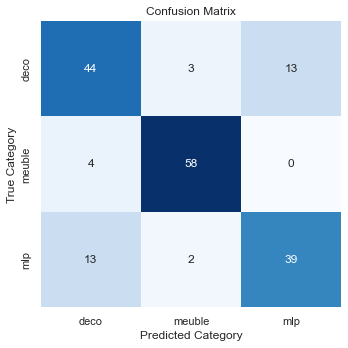

In [52]:
# Evaluating performance of KNN on dataset - all features
evaluation(model, X_train, y_train, X_test, y_test, index_act)

Accuracy: 0.801
Confusion Matrix: [[42  1 17]
 [ 5 57  0]
 [12  0 42]]


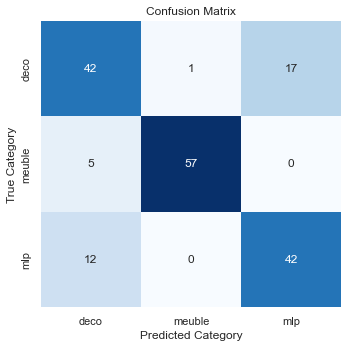

In [53]:
# Evaluating performance of KNN on dataset 1 - 4 initial features
evaluation(model, X_train_1, y_train, X_test_1, y_test, index_act)

Accuracy: 0.761
Confusion Matrix: [[38  5 17]
 [ 5 57  0]
 [13  2 39]]


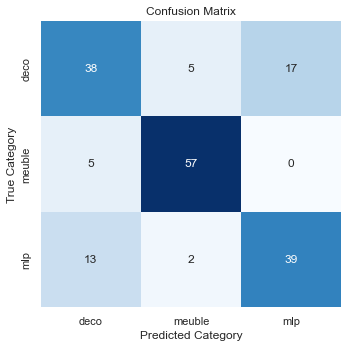

In [54]:
# Evaluating performance of KNN on dataset 2 - best features 
evaluation(model, X_train_2, y_train, X_test_2, y_test, index_act)

In [55]:
# We consider the full dataset for the next visualisations, as it provides the best result

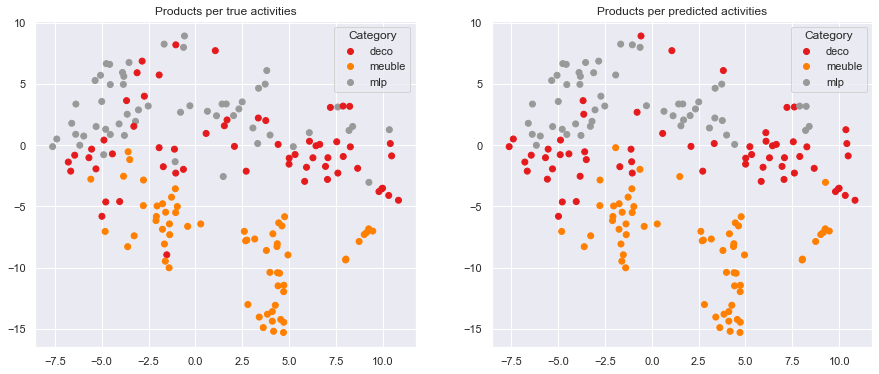

In [56]:
# Visualising projection TSNE 2D of true activities and predicted categories 
tsne = TSNE(n_components=2, init='pca')
X_test_red = tsne.fit_transform(X_test)
X_train_red = tsne.fit_transform(X_train)

fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
scatter = plt.scatter(X_test_red[:,0],X_test_red[:,1], c=y_test, cmap='Set1')
plt.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Category")
plt.title('Products per true activities')

ax = fig.add_subplot(122)
scatter = plt.scatter(X_test_red[:,0],X_test_red[:,1], c=y_pred, cmap='Set1')
plt.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Category")
plt.title('Products per predicted activities')

plt.show()

Comments - Supervised Classification
- The evaluation metrics chosen are Accuracy and Confusion matrix - they allow to observe in which way the model is wrong (or right!). 
- The algo picked first is KNN as widely used in multiclass, good for small dataset, good for small number of features, is not impacted by outliers, good with correlated features. A randomforest could be another good choice as more stable.
- Using the gridsearch varying scalers (but same principle for varying hyperparameters), and obtain best preprocessing/algo.
- Considering this best model to evaluate datasets as per features selection.
- Best accuracy is 80% with the dataset with all features

# Part 4 : Modeling - Clustering

We reached an 80% accuracy with supervised learning. Let's check if:
- clustering will identify 3 clusters as best clustering number
- clustering into 3 groups provides us distinct clusters from the features we got.

# <a name="C17">Evaluation metric</a>

Given it is a clustering exercise and to answer the questions above, we will consider both :
- the metrics silhouette and davies bouldin to determine best cluster number
- the metric ARI to determine clustering performance

# <a name="C18">KMeans</a>

The choice for KMeans is justified by:
- widely used in clustering

Best cluster - silhouette:  3
Best cluster - db:  3


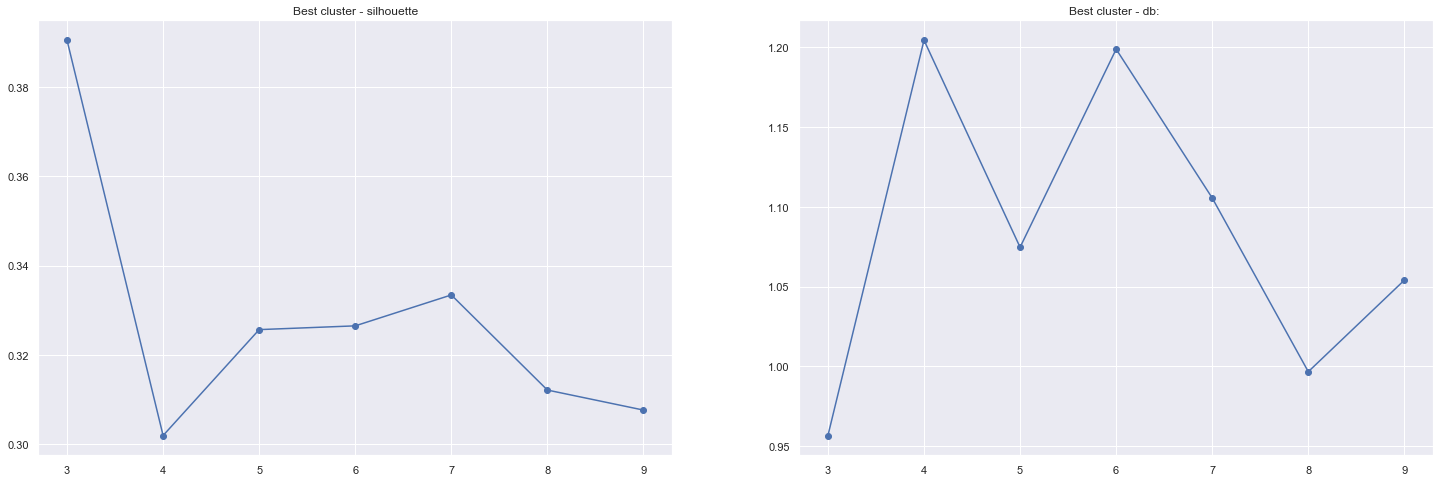

In [57]:
# Researching and visualising the best cluster for the algo KMeans considering the calculation of the silhouette score and DB score
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(121)
silhouettes = []
for num_clusters in range(3, 10):
        cls = cluster.KMeans(n_clusters = num_clusters, n_init=1, init='random')
        cls.fit(X_train)
        silh = metrics.silhouette_score(X_train, cls.labels_)
        silhouettes.append(silh)
ax.plot(range(3,10), silhouettes, marker='o')
plt.title("Best cluster - silhouette")

ax = fig.add_subplot(122)
davies_bouldin = []
for num_clusters in range(3, 10):
        cls = cluster.KMeans(n_clusters = num_clusters, n_init=1, init='random')
        cls.fit(X_train)
        db = metrics.davies_bouldin_score(X_train, cls.labels_)
        davies_bouldin.append(db)
ax.plot(range(3,10), davies_bouldin, marker='o')
plt.title("Best cluster - db: ")

print ("Best cluster - silhouette: ", silhouettes.index(max(silhouettes))+3)
print ("Best cluster - db: ", davies_bouldin.index(min(davies_bouldin))+3)

best_kcluster = silhouettes.index(max(silhouettes))+3

Adjusted Rand Index: 0.117


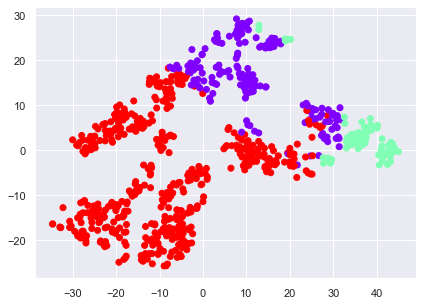

In [58]:
# Visualising the 3 clusters on TSNE 2D projection 
fig = plt.figure(figsize=(15,5))

clsKM3 = cluster.KMeans(n_clusters=3)
clsKM3.fit(X_train)
ax = fig.add_subplot(122)
ax.scatter(X_train_red[:,0], X_train_red[:, 1], c=clsKM3.labels_, cmap='rainbow')
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_train, clsKM3.labels_))

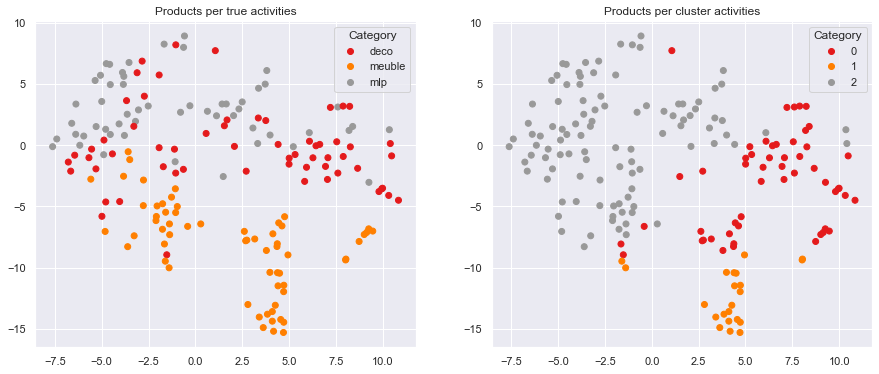

In [59]:
# Visualising projection TSNE 2D of true activities and clusters 

y_pred = clsKM3.predict(X_test)

fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
scatter = plt.scatter(X_test_red[:,0],X_test_red[:,1], c=y_test, cmap='Set1')
plt.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Category")
plt.title('Products per true activities')

ax = fig.add_subplot(122)
scatter = plt.scatter(X_test_red[:,0],X_test_red[:,1], c=y_pred, cmap='Set1')
plt.legend(handles=scatter.legend_elements()[0], labels=set(y_pred), loc="best", title="Category")
plt.title('Products per cluster activities')

plt.show()

Comments - Clustering
- The evaluation metrics chosen are silhouette and DB for best cluster numbers and ARI for performance. 
- The algo picked first is KMeans as commonly used in multiclass
- Best cluster number is 3 for both metrics, but 2D visualisation does not distinguish well the clusters.
- ARI is 6%, very bad. The features do not provide a good clustering with KMeans

# Part 4 : Conclusions

# <a name="C17">Feasibility</a>

Comments - 
- 80% is acceptable for accuracy in this context (balanced data, and small dataset), which leads to feasbility with supervised classification. Prediction of the classification issued from the KNN model trained on the 3 activities is acceptable, but not high enough.
- Feasbility not conclusive at all with clustering. Bad performance and bad visualisation of clusters not clearly identified

# <a name="C18">Improvements</a>

Comments - 
- Need a larger database – 300 products per activity is low
- Need more variables (picture, price, …) to better qualify a product to an activity
- Review assignment of activities to certain products – maybe initially miscategorised?
- Consideration of other pre-processing techniques specific to e-commerce
- Consideration of other algorithms and hyperparameters optimisation

The end of notebook